In [2]:
import os
import random
from collections import defaultdict
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score

import warnings
# filter warnings
warnings.filterwarnings('ignore')

C:\Users\Nolan\AppData\Local\Temp\ipykernel_36636\3081382395.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name())
else:
    print("⚠️ GPU is NOT active! Go to Runtime → Change runtime type → GPU")


CUDA available: False
⚠️ GPU is NOT active! Go to Runtime → Change runtime type → GPU


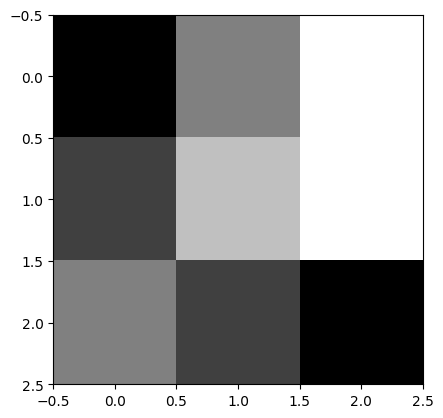

In [2]:
data = [[0, 128, 255], [64, 192, 255], [128, 64, 0]]
plt.imshow(data, cmap='gray')
plt.show()

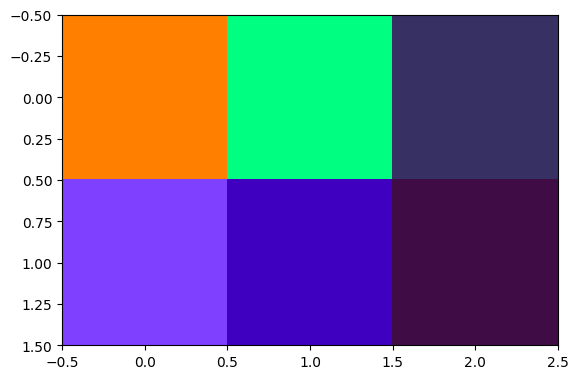

(2, 3, 3)

In [3]:
data = [[[255, 0, 54], [128, 64, 64]], [[128, 255, 49], [64, 0, 12]], [[0, 128, 98], [255, 192, 70]]]
data = np.moveaxis(data, 0, -1)
plt.imshow(data)
plt.show()
data.shape


In [7]:
print(os.getcwd())
print(os.listdir())

/content
['.config', 'sample_data']


In [ ]:
data_path = os.path.join('SIGNS dataset')
splits = ['train_signs', 'test_signs']

for s in splits:
    folder = os.path.join(data_path, s)
    files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
    print(f'{len(files)} images in {s}')

    # for each image, create a list of the type [class, filename]
    files = [f.split('_',1) for f in files]

    # group the data by class
    files_by_sign = defaultdict(list)
    for k, v in files:
        files_by_sign[k].append(v)
    
      # take random 4 images of each class  
    for k, v in sorted(files_by_sign.items()):
        print(f'Number of examples for class {k}:', len(v))

        # display several examples of images from the training sample   
        if s == 'train_signs':        
            random.seed(42)
        
            imgs_path = random.sample(v, 5)
            imgs_path = [os.path.join(data_path, f'{s}/{k}_{p}') for p in imgs_path]

            # read the image using the opencv library
            imgs = [cv2.imread(p) for p in imgs_path]
            # matplotlib expects img in RGB format but OpenCV provides it in BGR       
            # transform the BGR image into RGB
            imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]

                  # create a figure for display
            fig = plt.figure(figsize=(9, 2))
            grid = ImageGrid(
                fig, 111, 
                nrows_ncols=(1, 5)
            )
            # display the image
            for ax, img in zip(grid, imgs):
                ax.imshow(img)

            fig.suptitle(f'Class {k}, {s.capitalize()} split')
            plt.show()



SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (ipython-input-1738597277.py, line 1)

In [ ]:
orig_img = Image.fromarray(img)

def plot_examples(transformed_imgs:list, col_titles:list, cmap=None):
    
    n_cols = len(transformed_imgs) +1
    fig_size_x = 3 + len(transformed_imgs) * 1.5
    fig, axs = plt.subplots(1, n_cols, figsize=(fig_size_x,2))
    
    axs[0].imshow(orig_img)
    axs[0].set_title('original image')
    
    for i in range(len(transformed_imgs)):
        axs[i+1].imshow(transformed_imgs[i], cmap=cmap)
        axs[i+1].set_title(col_titles[i])
    
    plt.tight_layout()
    plt.show()


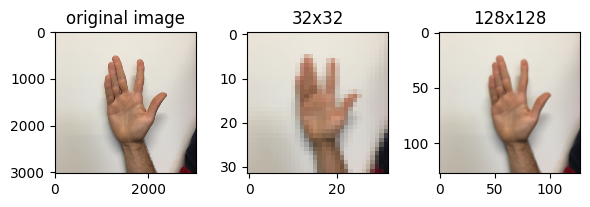

In [ ]:
"""Resize
Аугментація з використанням resize уніфікує розміри вхідних зображень, 
забезпечуючи сумісність з мережею. Також вона збільшує обсяг навчального набору даних, 
роблячи модель стійкішою до масштабних варіацій."""

resized_imgs = [T.Resize(size=size)(orig_img) for size in [32,128]]
plot_examples(resized_imgs, ['32x32', '128x128'])

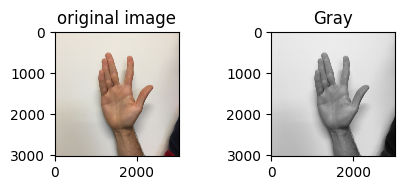

In [ ]:
"""Gray Scale
Аугментація з використанням Gray Scale перетворює кольорові зображення на відтінки сірого. 
Це зменшує кількість каналів зображення, що може спростити роботу моделі, 
і зменшити вимоги до обчислювальних ресурсів"""

gray_img = T.Grayscale()(orig_img)
plot_examples([gray_img], ["Gray"], 'gray')

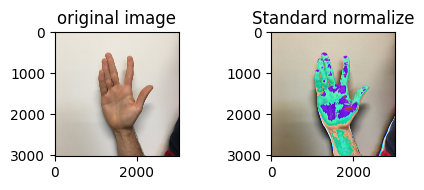

In [ ]:
"""Normalize
Нормалізація може стати ефективним способом прискорення обчислень у моделі, 
заснованій на архітектурі нейронної мережі, і швидше навчатися. Є два кроки для нормалізації зображень:
- віднімаємо середнє значення каналу з кожного вхідного каналу,
- ділимо його на стандартне відхилення каналу."""

normalized_img = T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(T.ToTensor()(orig_img)) 
normalized_img = [T.ToPILImage()(normalized_img)]
plot_examples(normalized_img, ["Standard normalize"])

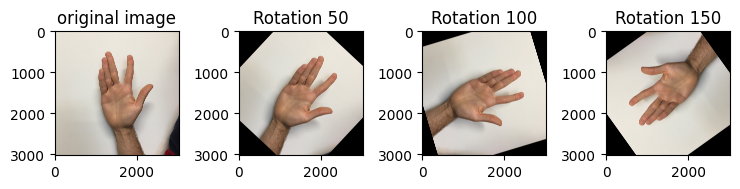

In [ ]:
"""Random Rotation
Аугментація з використанням "Random Rotation" обертає зображення на випадковий кут. 
Це допомагає моделі стати стійкішою до різних кутів розміщення об'єктів на зображеннях."""

rotated_imgs = [T.RandomRotation(degrees=d)(orig_img) for d in range(50,151,50)]
plot_examples(rotated_imgs, ["Rotation 50","Rotation 100","Rotation 150"])

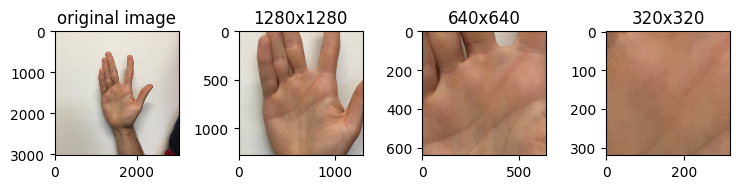

In [ ]:
"""Center Crop
Аугментація з використанням Center Crop вирізає центральну частину зображення.
Це забезпечує фокусування на основних об'єктах та уніфікує розмір вхідних зображень."""

center_crops = [T.CenterCrop(size=size)(orig_img) for size in (1280,640, 320)]
plot_examples(center_crops,['1280x1280','640x640','320x320'])

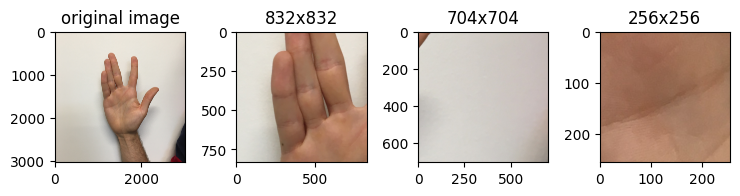

In [ ]:
"""Random Crop
Аугментація з використанням "Random Crop" вирізає випадкову частину зображення. 
Це допомагає моделі стати стійкішою до ситуацій, коли об’єкт видно частково, 
і збільшує варіативність навчального набору даних."""

random_crops = [T.RandomCrop(size=size)(orig_img) for size in (832,704, 256)]
plot_examples(random_crops,['832x832','704x704','256x256'])

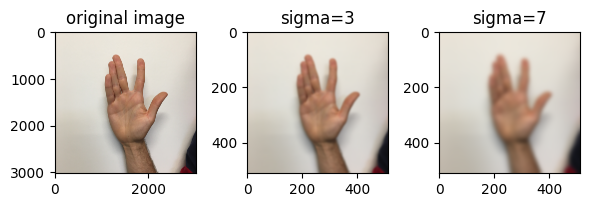

In [ ]:
"""Gaussian Blur
Ми застосовуємо до зображення перетворення розмиття Гауса за допомогою ядра Гауса. 
Цей метод може бути корисним для того, щоб зробити зображення менш чітким і виразним. 
Потім отримане зображення подається в нейронну мережу, яка стає надійнішою у вивченні ознак вхідних даних."""

downsized_img = T.Resize(size=512)(orig_img)
blurred_imgs = [T.GaussianBlur(kernel_size=(51, 91), sigma=sigma)(downsized_img) for sigma in (3,7)]
plot_examples(blurred_imgs, ['sigma=3', 'sigma=7'])

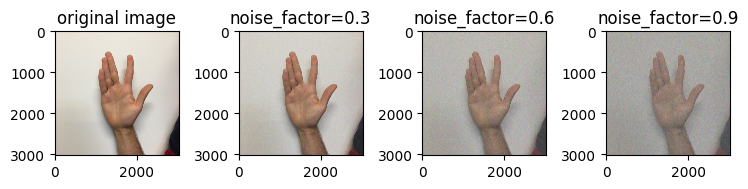

In [ ]:
"""Gaussian Noise
Шум Гауса — це популярний спосіб додати шум до всього набору даних, змушуючи модель вивчати найважливішу інформацію, що міститься в даних. 
Він полягає у впровадженні матриці шуму Гауса, яка є матрицею випадкових значень, взятих із розподілу Гауса. 
Пізніше ми обрізаємо зразки між 0 і 1. Чим вищий коефіцієнт шуму, тим шумніше зображення."""

def add_noise(inputs,noise_factor=0.3):
    noisy = inputs+torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy
    
noise_imgs = [add_noise(T.ToTensor()(orig_img),noise_factor) for noise_factor in (0.3,0.6,0.9)]
noise_imgs = [T.ToPILImage()(noise_img) for noise_img in noise_imgs]
plot_examples(noise_imgs, ["noise_factor=0.3","noise_factor=0.6","noise_factor=0.9"])


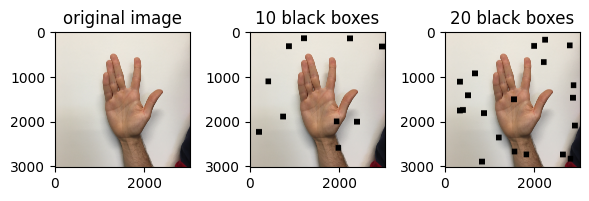

In [ ]:
"""Random Blocks
Квадратні плями застосовуються як маски на зображенні випадковим чином. 
Чим більша кількість цих патчів, тим складнішою для нейронної мережі буде вирішення проблеми."""

def add_random_boxes(img,n_k,size=32):
    h,w = size,size
    img = np.array(img).copy()
    img_size = img.shape[1]
    boxes = []
    for k in range(n_k):
        y,x = np.random.randint(0,img_size-w,(2,))
        img[y:y+h,x:x+w] = 0
        boxes.append((x,y,h,w))
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    return img

blocks_imgs = [add_random_boxes(orig_img,n_k=i, size=128) for i in (10, 20)]
plot_examples(blocks_imgs, ["10 black boxes","20 black boxes"])


In [ ]:
class SIGNSDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.filename = os.listdir(data_dir)
        self.filename = [os.path.join(data_dir, f) for f in self.filename if f.endswith('.jpg')]

        self.labels = [int(filename.split('/')[-1][0]) for filename in self.filename]
        self.transform = transform
    
    def __len__(self):
        return len(self.filename)
    
    def __getitem__(self, idx):
        img = Image.open(self.filename[idx])
        img = self.transform(img)
        label = self.labels[idx]
        return img, label



In [ ]:
train_transformer = T.Compose([
    T.Resize(64),              # resizing the image to 64x64 
    T.RandomHorizontalFlip(),  # randomly flip image horizontally
    T.ToTensor()])             # transform it into a PyTorch Tensor

eval_transformer = T.Compose([
    T.Resize(64),
    T.ToTensor()])

In [ ]:
train_dataset = SIGNSDataset(f'{data_path}/train_signs/', train_transformer)
test_dataset = SIGNSDataset(f'{data_path}/test_signs/', eval_transformer)


In [ ]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_channels = 32

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

        # classification layers
        self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)  # 6 classes

    def forward(self, s):
        s = self.conv1(s)
        s = F.relu(F.max_pool2d(s, 2))
        s = self.conv2(s)
        s = F.relu(F.max_pool2d(s, 2))
        s = self.conv3(s)
        s = F.relu(F.max_pool2d(s, 2))
        s = s.view(-1, self.num_channels*4*8*8)
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        return F.log_softmax(s, dim=1)


In [ ]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=32, 
                              shuffle=True,
                              num_workers=0)

test_dataloader = DataLoader(test_dataset,
                             batch_size=32, 
                             shuffle=False,
                             num_workers=0)


In [ ]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else None

torch.manual_seed(42)
if cuda:
    cuda.manual_seed(42)
model = BaselineModel().to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)    

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

num_epochs = 15

In [ ]:
for epoch in tqdm(range(num_epochs)):
   
  # Train step
   
  model.train()
   
  train_epoch_loss = []
  train_epoch_acc = []
   
  for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader)):
    if cuda:
		    # non_blocking=True enables asynchronous data transfer to reduce runtime
		    train_batch, labels_batch = train_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

    # compute model output and loss
    output_batch = model(train_batch)

    loss = criterion(output_batch, labels_batch)

    # clear previous gradients, compute gradients of all variables wrt loss
    optimizer.zero_grad()
    loss.backward()

    # performs updates using calculated gradients
    optimizer.step()
     
    batch_loss = loss.cpu().detach().numpy()
    batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                      labels_batch.cpu().detach().numpy())
     
    train_epoch_loss.append(batch_loss)
    train_epoch_acc.append(batch_acc)
     
   
  print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
  train_accuracies.append(np.mean(train_epoch_acc))
  train_losses.append(np.mean(train_epoch_loss))
   
  # Eval step
   
  model.eval()
   
  test_epoch_loss = []
  test_epoch_acc = []
   
  with torch.no_grad():
     
    for i, (test_batch, labels_batch) in enumerate(test_dataloader):
      if cuda:
        test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

      # compute model output and loss
      output_batch = model(test_batch)

      loss = criterion(output_batch, labels_batch)

      batch_loss = loss.cpu().detach().numpy()
      batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                        labels_batch.cpu().detach().numpy())

      test_epoch_loss.append(batch_loss)
      test_epoch_acc.append(batch_acc)
  print(f'Test epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
  test_accuracies.append(np.mean(test_epoch_acc))
  test_losses.append(np.mean(test_epoch_loss))
    

34it [01:18,  2.30s/it]00:00<?, ?it/s]


Train epoch [1/15], Loss: 1.7951, Acc: 0.15646271949640073


  7%|▋         | 1/15 [01:27<20:18, 87.01s/it]

Test epoch [1/15], Loss: 1.7897, Acc: 0.18446368446368447


34it [01:04,  1.90s/it]


Train epoch [2/15], Loss: 1.7524, Acc: 0.2900619213498739


 13%|█▎        | 2/15 [02:38<16:51, 77.78s/it]

Test epoch [2/15], Loss: 1.5839, Acc: 0.31093750000000003


34it [01:06,  1.97s/it]


Train epoch [3/15], Loss: 1.3729, Acc: 0.5344457650176099


 20%|██        | 3/15 [03:52<15:14, 76.18s/it]

Test epoch [3/15], Loss: 1.2111, Acc: 0.3729601648351648


34it [01:07,  1.99s/it]


Train epoch [4/15], Loss: 1.1195, Acc: 0.6100178688413982


 27%|██▋       | 4/15 [05:07<13:52, 75.67s/it]

Test epoch [4/15], Loss: 0.9780, Acc: 0.3583054676804677


34it [01:07,  1.99s/it]


Train epoch [5/15], Loss: 0.8214, Acc: 0.7298035325241207


 33%|███▎      | 5/15 [06:22<12:33, 75.39s/it]

Test epoch [5/15], Loss: 0.8735, Acc: 0.43416053921568626


34it [01:07,  1.99s/it]


Train epoch [6/15], Loss: 0.6218, Acc: 0.8174699619552561


 40%|████      | 6/15 [07:37<11:18, 75.35s/it]

Test epoch [6/15], Loss: 0.5607, Acc: 0.6164720695970696


34it [01:05,  1.93s/it]


Train epoch [7/15], Loss: 0.4400, Acc: 0.8568719406954701


 47%|████▋     | 7/15 [08:50<09:55, 74.43s/it]

Test epoch [7/15], Loss: 0.5282, Acc: 0.5439111935822463


34it [01:05,  1.92s/it]


Train epoch [8/15], Loss: 0.3654, Acc: 0.8895205012852072


 53%|█████▎    | 8/15 [10:02<08:36, 73.75s/it]

Test epoch [8/15], Loss: 0.4450, Acc: 0.5461111111111111


34it [01:05,  1.92s/it]


Train epoch [9/15], Loss: 0.3120, Acc: 0.9013305322128852


 60%|██████    | 9/15 [11:14<07:19, 73.25s/it]

Test epoch [9/15], Loss: 0.4132, Acc: 0.5601975638740344


34it [01:03,  1.87s/it]


Train epoch [10/15], Loss: 0.2325, Acc: 0.923768674136321


 67%|██████▋   | 10/15 [12:25<06:02, 72.45s/it]

Test epoch [10/15], Loss: 0.4436, Acc: 0.6676587301587301


34it [01:03,  1.88s/it]


Train epoch [11/15], Loss: 0.1769, Acc: 0.9409603740486094


 73%|███████▎  | 11/15 [13:36<04:47, 71.98s/it]

Test epoch [11/15], Loss: 0.4085, Acc: 0.5986694677871148


34it [01:19,  2.34s/it]


Train epoch [12/15], Loss: 0.1346, Acc: 0.947659543615426


 80%|████████  | 12/15 [15:03<03:50, 76.67s/it]

Test epoch [12/15], Loss: 0.3518, Acc: 0.5729377104377105


34it [01:05,  1.93s/it]


Train epoch [13/15], Loss: 0.1331, Acc: 0.9438334677305266


 87%|████████▋ | 13/15 [16:16<02:30, 75.47s/it]

Test epoch [13/15], Loss: 0.2827, Acc: 0.7074965339671222


34it [01:03,  1.88s/it]


Train epoch [14/15], Loss: 0.1317, Acc: 0.9627787680728858


 93%|█████████▎| 14/15 [17:27<01:14, 74.07s/it]

Test epoch [14/15], Loss: 0.2661, Acc: 0.6811326694139194


34it [01:07,  1.98s/it]


Train epoch [15/15], Loss: 0.0899, Acc: 0.9664495798319327


100%|██████████| 15/15 [18:42<00:00, 74.85s/it]

Test epoch [15/15], Loss: 0.3042, Acc: 0.6302158489658489
